In [1]:
### ----- Imports ----- ###

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os.path
import os
import shutil
import glob
import h5py
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from scipy import stats

dataset = 'v1b'

2023-09-26 20:56:59.776013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-26 20:56:59.776034: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
### ----- Parameters ----- ###

# Where to save the products
models_figs_path = '/home/sdybing/mlaapde/testdata_preds/noiseprop_training/figures/'

# MLAAPDE/data generation params
sr = 20 # Sampling rate
trim_sec = 60 # Trimming amount around phase pick to get from MLAAPDE
trim_pre_sec = trim_sec
trim_post_sec = trim_pre_sec
window_len = trim_pre_sec + trim_post_sec
n_channels = 3 # Instrument channels
cut_lens = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
cut_lens_finish = [70, 80, 90, 100, 110, 120]
cut_lens_test = [70]
desired_shift = 3
max_shift = desired_shift * 2 # Since the shifting method actually makes it half what this value is set to
min_snr_db = False
max_snr_db = False
log_progress_fraction = 100
valid_phases = ['P', 'Pn', 'Pg']
cast_dtype = np.float32

# Training/model params
epochs_number = 200
batch_size = int(256) # Reducing to help memory
monte_carlo_sampling = 50
drop_rate = 0.5
filters = [32, 64, 96, 128, 256] 

# Used if loading a trained model
training_dataset = 'v1b'
shift_status = 'shifted'
model_folder_path = '/home/sdybing/mlaapde/training/noiseprop_training/'

# To make end error plots
mean_errors = []
std_errors = []

In [3]:
### ----- Load the MLAAPDE testing dataset from HDF5 files ----- ###

hdf5_save_dir = '/hdd/mlaapde/decimated'

testing_data = h5py.File(hdf5_save_dir + '/testing_data.hdf5', 'r')
test_waves = testing_data['waves'][:]
test_mags = testing_data['magnitude'][:]
test_phase_id = testing_data['phase_id'][:]

testing_data.close()

In [4]:
train_data = h5py.File(hdf5_save_dir + '/training_data_full_decimate2.hdf5', 'r')
train_mags = train_data['magnitude'][:]

In [5]:
min(train_mags)

0.0

In [6]:
max(train_mags)

8.3

In [7]:
test_waves_t = test_waves.transpose(0,2,1)

print(test_waves_t.shape)
print(test_mags.shape)

(324365, 2400, 3)
(324365,)


In [8]:
del test_waves

In [9]:
nsamp = 2920609
n_test_samp = len(test_mags)
data = 'testing'

In [10]:
### ----- Load the historic testing dataset ----- ###

historic_path = '/hdd/mlaapde/decimated/'

historic_test_waves = np.load(historic_path + 'historic_test_waves.npy')
historic_test_mags = np.load(historic_path + 'historic_test_mags.npy')
print(historic_test_waves.shape)
n_channels_hist = 3

bad_hist_indices = np.loadtxt('/home/sdybing/mlaapde/codes/bad_historic_waves.txt').astype(int)

historic_test_waves_nonan = np.delete(historic_test_waves, bad_hist_indices, axis = 0)
historic_test_mags_nonan = np.delete(historic_test_mags, bad_hist_indices, axis = 0)

print(historic_test_waves.shape)
print(historic_test_waves_nonan.shape)
print(historic_test_mags.shape)
print(historic_test_mags_nonan.shape)

n_historic_test_samp = len(historic_test_waves_nonan)

(13449, 2400, 3)
(13449, 2400, 3)
(13151, 2400, 3)
(13449,)
(13151,)


---------------------------------
Cut len: 70
Shift len: 64
Loading weights...
Predicting...


2023-09-26 21:53:21.319104: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5184245760 exceeds 10% of free system memory.


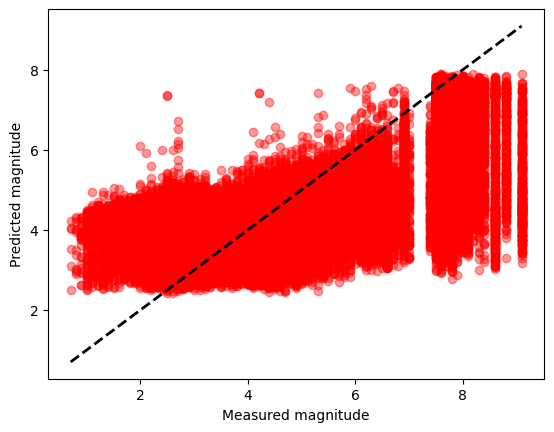

Mean error: -0.057
Median error: -0.116
Error standard deviation: 1.04
Calculating and saving bin stats...


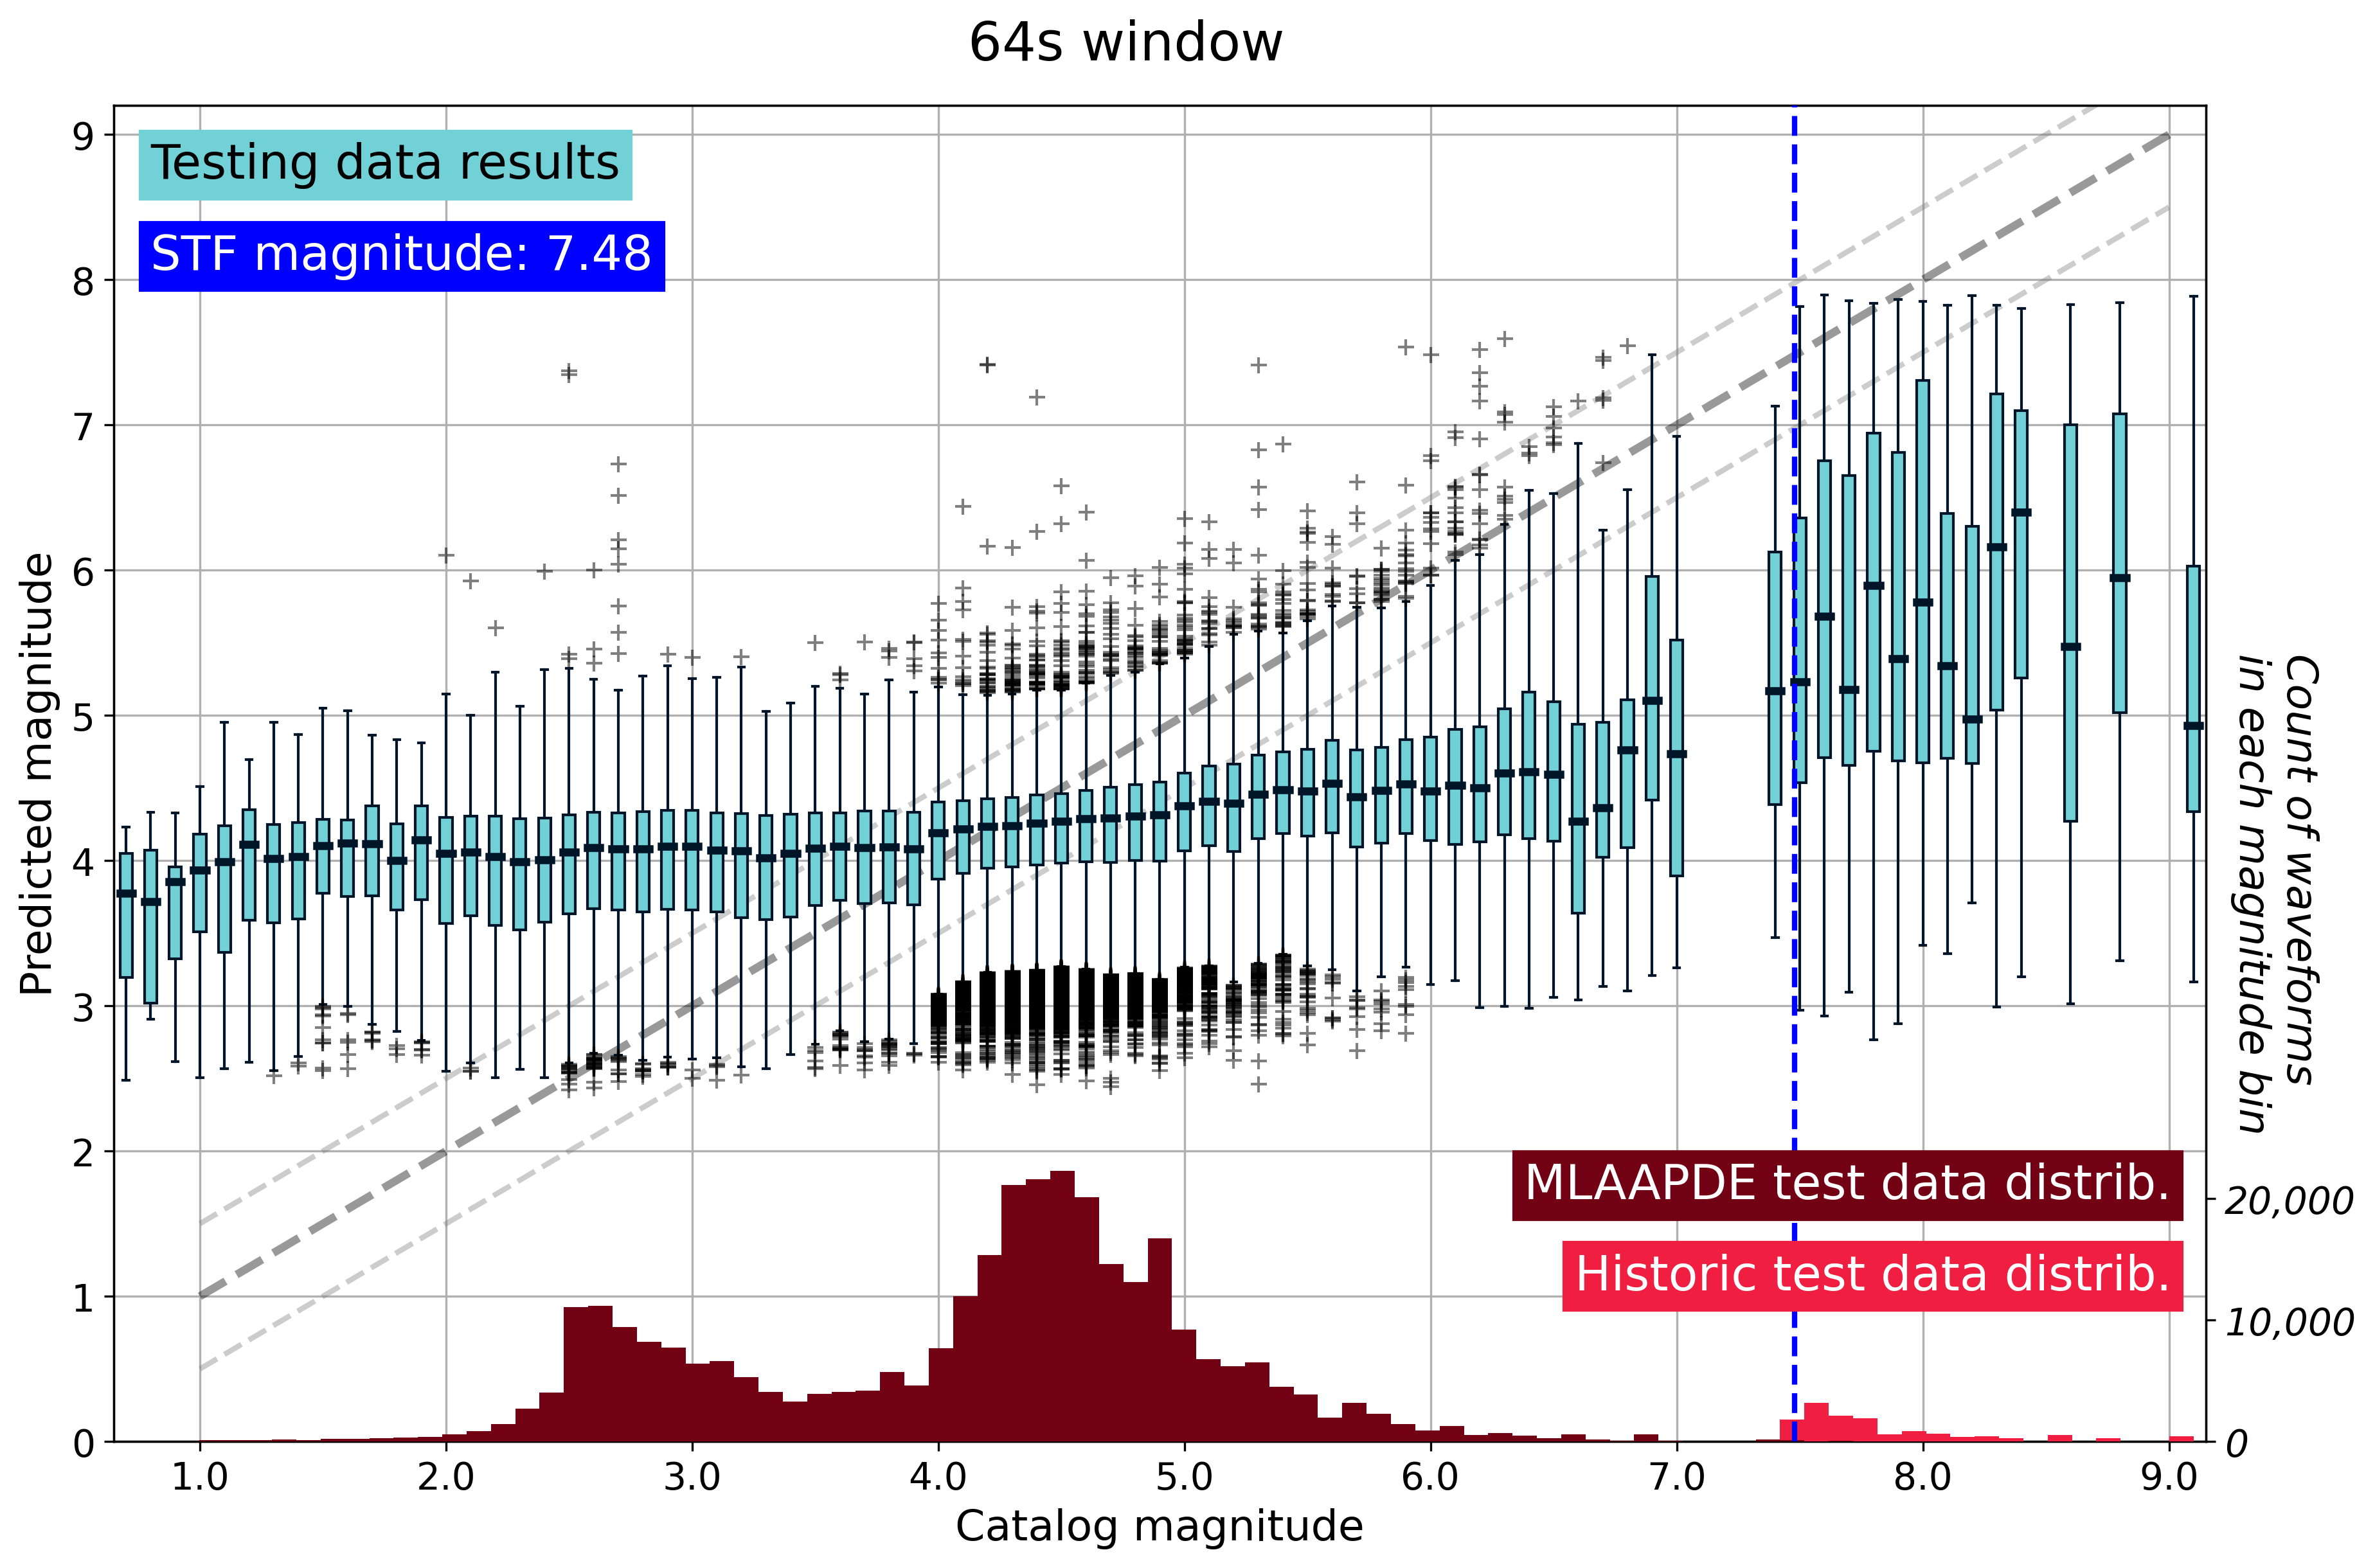

In [19]:
### THE LOOP ###

# Just using MLAAPDE or historic too?
mlaa_only = False
debug = False

for cut_len in cut_lens_test:
    print('---------------------------------')
    print('Cut len: ' + str(cut_len))
    print('Shift len: ' + str(cut_len-6))
        
    ### ----- MLAAPDE DATA ----- ###
    
    ### ----- Cut and shift testing data to match the training data ----- ###
    ## Cut ##
    if debug:
        rand = np.random.choice(np.arange(0,len(test_mags),1))
        print('Rand: ' + str(rand))
        test_times = np.arange(0, window_len, 1/sr)
        plt.figure(facecolor = 'white')
        plt.suptitle('Original test data')
        plt.subplot(311)
        plt.plot(test_times, test_waves_t[rand,:,0], color = 'C0')
        plt.subplot(312)
        plt.plot(test_times, test_waves_t[rand,:,1], color = 'C1')
        plt.subplot(313)
        plt.plot(test_times, test_waves_t[rand,:,2], color = 'C2')
        plt.subplots_adjust(hspace = 0)
        plt.show();
    
    middle = int(test_waves_t.shape[1] / 2)
    if debug: print('Middle: ' + str(middle))
    test_size = int(n_test_samp)
    if debug: print('test size: ' + str(test_size))
    cut_test_waves_t = np.zeros((test_size, int(cut_len*sr), 3)) 
    if debug: print('Cut waves t shape: ' + str(cut_test_waves_t.shape))

    for i in range(len(test_waves_t)):
        cut_test_waves_t[i,] = test_waves_t[i, int(middle - (cut_len/2)*sr) : int(middle + (cut_len/2)*sr), 0:3]
    if debug: print('Cut waves t shape: ' + str(cut_test_waves_t.shape))
    if debug:
        test_cut_times = np.arange(0, cut_len, 1/sr)
        print('Rand: ' + str(rand))
        plt.figure(facecolor = 'white')
        plt.suptitle('Cut test data')
        plt.subplot(311)
        plt.plot(test_cut_times, cut_test_waves_t[rand,:,0], color = 'C0')
        plt.subplot(312)
        plt.plot(test_cut_times, cut_test_waves_t[rand,:,1], color = 'C1')
        plt.subplot(313)
        plt.plot(test_cut_times, cut_test_waves_t[rand,:,2], color = 'C2')
        plt.subplots_adjust(hspace = 0)
        plt.show();

    ## Shift ##
    shift_len = cut_len - max_shift
    if debug: print('Shift len: ' + str(shift_len))
    time_offset = np.random.uniform(low = 0, high = max_shift, size = test_size)
    shift_test_waves_t = np.zeros((test_size, int(shift_len * sr), 3)) 

    for ii, offset in enumerate(time_offset):
        bin_offset = int(offset * sr)
        start_bin = bin_offset 
        end_bin = int(start_bin + shift_len * sr)
        shift_test_waves_t[ii, :, 0] = cut_test_waves_t[ii, start_bin:end_bin, 0] 
        shift_test_waves_t[ii, :, 1] = cut_test_waves_t[ii, start_bin:end_bin, 1]
        shift_test_waves_t[ii, :, 2] = cut_test_waves_t[ii, start_bin:end_bin, 2]

    if debug: print('Shift waves t shape: ' + str(shift_test_waves_t.shape))
    if debug:
        test_shift_times = np.arange(0, shift_len, 1/sr)
        print('Rand: ' + str(rand))
        plt.figure(facecolor = 'white')
        plt.suptitle('Shifted test data')
        plt.subplot(311)
        plt.plot(test_shift_times, shift_test_waves_t[rand,:,0], color = 'C0')
        plt.subplot(312)
        plt.plot(test_shift_times, shift_test_waves_t[rand,:,1], color = 'C1')
        plt.subplot(313)
        plt.plot(test_shift_times, shift_test_waves_t[rand,:,2], color = 'C2')
        plt.subplots_adjust(hspace = 0)
        plt.show();
        
    ### ----- HISTORIC DATA ----- ###
    
    ## Cut ##
    if debug:
        rand = np.random.choice(np.arange(0,len(historic_test_mags_nonan),1))
        print('Rand: ' + str(rand))
        historic_test_times = np.arange(0, window_len, 1/sr)
        plt.figure(facecolor = 'white')
        plt.suptitle('Original historic test data')
        plt.subplot(311)
        plt.plot(historic_test_times, historic_test_waves_nonan[rand,:,0], color = 'C0')
        plt.subplot(312)
        plt.plot(historic_test_times, historic_test_waves_nonan[rand,:,1], color = 'C1')
        plt.subplot(313)
        plt.plot(historic_test_times, historic_test_waves_nonan[rand,:,2], color = 'C2')
        plt.subplots_adjust(hspace = 0)
        plt.show();

    middle = int(historic_test_waves_nonan.shape[1] / 2)
    if debug: print('Middle: ' + str(middle))
    historic_test_size = int(n_historic_test_samp)
    if debug: print('historic test size: ' + str(historic_test_size))
    cut_historic_test_waves_nonan = np.zeros((historic_test_size, int(cut_len*sr), 3)) 
    if debug: print('Cut waves shape: ' + str(cut_historic_test_waves_nonan.shape))

    for i in range(len(historic_test_waves_nonan)):
        cut_historic_test_waves_nonan[i,] = historic_test_waves_nonan[i, int(middle - (cut_len/2)*sr) : int(middle + (cut_len/2)*sr), 0:3]
    if debug: print('Cut waves shape: ' + str(cut_historic_test_waves_nonan.shape))
    if debug:
        historic_test_cut_times = np.arange(0, cut_len, 1/sr)
        print('Rand: ' + str(rand))
        plt.figure(facecolor = 'white')
        plt.suptitle('Cut historic test data')
        plt.subplot(311)
        plt.plot(historic_test_cut_times, cut_historic_test_waves_nonan[rand,:,0], color = 'C0')
        plt.subplot(312)
        plt.plot(historic_test_cut_times, cut_historic_test_waves_nonan[rand,:,1], color = 'C1')
        plt.subplot(313)
        plt.plot(historic_test_cut_times, cut_historic_test_waves_nonan[rand,:,2], color = 'C2')
        plt.subplots_adjust(hspace = 0)
        plt.show();

    ## Shift ##
    shift_len = cut_len - max_shift
    if debug: print('Shift len: ' + str(shift_len))
    time_offset = np.random.uniform(low = 0, high = max_shift, size = historic_test_size)
    shift_historic_test_waves_nonan = np.zeros((historic_test_size, int(shift_len * sr), 3)) 

    for ii, offset in enumerate(time_offset):
        bin_offset = int(offset * sr)
        start_bin = bin_offset 
        end_bin = int(start_bin + shift_len * sr)
        shift_historic_test_waves_nonan[ii, :, 0] = cut_historic_test_waves_nonan[ii, start_bin:end_bin, 0] 
        shift_historic_test_waves_nonan[ii, :, 1] = cut_historic_test_waves_nonan[ii, start_bin:end_bin, 1]
        shift_historic_test_waves_nonan[ii, :, 2] = cut_historic_test_waves_nonan[ii, start_bin:end_bin, 2]

    if debug: print('Shift waves shape: ' + str(shift_historic_test_waves_nonan.shape))
    if debug:
        historic_test_shift_times = np.arange(0, shift_len, 1/sr)
        print('Rand: ' + str(rand))
        plt.figure(facecolor = 'white')
        plt.suptitle('Shifted historic test data')
        plt.subplot(311)
        plt.plot(historic_test_shift_times, shift_historic_test_waves_nonan[rand,:,0], color = 'C0')
        plt.subplot(312)
        plt.plot(historic_test_shift_times, shift_historic_test_waves_nonan[rand,:,1], color = 'C1')
        plt.subplot(313)
        plt.plot(historic_test_shift_times, shift_historic_test_waves_nonan[rand,:,2], color = 'C2')
        plt.subplots_adjust(hspace = 0)
        plt.show();

    ### ----- Initialize the model and training setup ----- ###

    inp1 = tf.keras.layers.Input(shape = (sr*(cut_len - max_shift), n_channels), name = 'input_layer') 
    e = tf.keras.layers.Conv1D(filters[1], 3, padding = 'same')(inp1) 
    e = tf.keras.layers.Dropout(drop_rate)(e, training = True)
    e = tf.keras.layers.MaxPooling1D(4, padding = 'same')(e)
    e = tf.keras.layers.Conv1D(filters[0], 3, padding = 'same')(e) 
    e = tf.keras.layers.Dropout(drop_rate)(e, training = True)
    e = tf.keras.layers.MaxPooling1D(4, padding = 'same')(e)
    e = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences = False, dropout = 0.0, recurrent_dropout = 0.0))(e)
    e = tf.keras.layers.Dense(1)(e)
    o = tf.keras.layers.Activation('linear', name = 'output_layer')(e)
    model = tf.keras.models.Model(inputs = [inp1], outputs = o)
    #model.summary()

    #model.compile(optimizer = 'Adam', loss = customLoss)
    model.compile(optimizer = 'Adam', loss = tf.keras.losses.MeanSquaredError())

    model_name = str(dataset) + '_' + str(nsamp) + 'samps_' + str(shift_len) + 's'
    m_name = str(model_name) + '_{epoch:03d}.h5' 
    
    ### ----- Combine the MLAAPDE and historic testing data ----- ###

    all_test_waves = np.concatenate((shift_test_waves_t, shift_historic_test_waves_nonan))
    # print(all_test_waves.shape)
    all_test_mags = np.concatenate((test_mags, historic_test_mags_nonan))
    # print(all_test_mags.shape)

    all_test_mags = np.round_(all_test_mags, decimals = 1) # Get rid of extra digits

    ### ----- What trained model are we loading? ----- ###
    
    model_path = model_folder_path + training_dataset + '_' + str(nsamp) + 'samps_' + str(shift_len) + 's_window/'
    # print(model_path)
    list_of_models = glob.glob(model_path + '*.h5') # * means all if need specific format then *.csv
    # print(list_of_models)
    numbers = []
    for item in list_of_models:
        numbers.append(item[-6:-3])
#     latest_model = model_path + training_dataset + '_' + str(nsamp) + 'samps_' + str(shift_len) + 's_' + max(numbers) + '.h5'
    latest_model = model_path + training_dataset + '_' + str(nsamp) + 'samps_' + str(shift_len) + 's_024.h5'
    # print('Model: ' + str(latest_model))

    print('Loading weights...')
    model.load_weights(latest_model)
    
    ### ----- Make the predictions ----- ###
    
    print('Predicting...')
    if mlaa_only == False:
        predict_all = model.predict(all_test_waves)
        all_test_mags = all_test_mags
        tag = '_all_test'
        np.save('/home/sdybing/mlaapde/testdata_preds/noiseprop_training/mag_preds/' + str(cut_len-6) + 's_window_magpreds.npy', predict_all)
        
    if mlaa_only == True:
        predict_all = model.predict(shift_test_waves_t)
        all_test_mags = test_mags
        tag = '_mlaa_only'
        np.save('/home/sdybing/mlaapde/testdata_preds/noiseprop_training/mag_preds/' + str(cut_len-6) + 's_window_magpreds_mlaa_only.npy', predict_all)

    # print(predict_all.shape)
    
    ## ----- Quick plot of the predictions vs. true magnitudes ----- ###

    fig4, ax = plt.subplots(facecolor = 'white')
    ax.scatter(all_test_mags, predict_all, alpha = 0.4, facecolors = 'r', edgecolors = 'r')
    ax.plot([all_test_mags.min(), all_test_mags.max()], [all_test_mags.min(), all_test_mags.max()], 'k--', alpha=1, lw=2)
    ax.set_xlabel('Measured magnitude')
    ax.set_ylabel('Predicted magnitude')
    plt.show()
#     fig4.savefig(models_figs_path + 'scatter_plots/' + str(cut_len-6) + 's_window_scatter_pred_vs_cat.png')
#     plt.close();
    
    ### ----- Rename things ----- ###

    measured_mags = all_test_mags
    predicted_mags = predict_all.flatten()

    ### ----- Calculate the error and standard deviation ----- ###

    errors = []

    for idx in range(len(predicted_mags)):
        predicted = predicted_mags[idx]
        measured = measured_mags[idx]
        error = predicted - measured
        errors.append(error)
        
    mean_error = np.mean(np.array(errors))
    median_error = np.median(np.array(errors))
    std_error = np.std(np.array(errors))
    
    # print('Error shape: ' + str(np.array(errors).shape))
    
    if mlaa_only == False:
        np.savetxt('/home/sdybing/mlaapde/testdata_preds/noiseprop_training/errors/' + str(cut_len-6) + 's_window_errors.txt', np.array(errors))
        
    if mlaa_only == True:
        np.savetxt('/home/sdybing/mlaapde/testdata_preds/noiseprop_training/mlaa_only/test_errors_' + str(cut_len-6) + 's_window_errors.txt', np.array(errors))

    print('Mean error: ' + str(round(mean_error,3)))
    print('Median error: ' + str(round(median_error,3)))
    print('Error standard deviation: ' + str(round(std_error,2)))
    
#     plt.figure(figsize = (8,6), dpi = 300)
#     plt.hist(errors, bins = 50, color = '#2DADB4')
#     plt.title(str(shift_len) + 's window: magnitude prediction errors', fontsize = 18)
#     plt.xlabel('Predicted - catalog magnitude', fontsize = 14)
#     plt.ylabel('Count', fontsize = 14)
#     plt.xticks(fontsize = 12)
#     plt.yticks(fontsize = 12)
#     plt.text(x = -0.055, y = 0.495, s = 'Mean: ' + str(round(mean_error,2)) + '\nSTD: ' + str(round(std_error,2)), fontsize = 18, backgroundcolor = 'lightgray', transform = ax.transAxes)
#     plt.savefig(save_dir + '/error_histogram_' + m_name + '.png', format = 'PNG', facecolor = 'white', transparent = False);
#     # plt.show();

    mean_errors.append(mean_error)
    std_errors.append(std_error)

    ### ----- Make the box and whisker plots with STF magnitude line ----- ###

    Tt = shift_len / 2
    M0_dyncm = Tt**3 * (0.625 * 10**23)
    Mw = ((2/3) * np.log10(M0_dyncm)) - 10.73 # M0 in dyne-cm

    # print('Rupture duration: ' + str(Tt) + ' seconds')
    # print('M0: ' + str(M0_dyncm) + ' dyne-cm')
    # print('Mw: ' + str(round(Mw,2)))

    bins = np.arange(7,92,1)/10
    data_bins = []

    for abin in bins:
    #     print(abin)
        i = np.where(measured_mags == abin)[0]
    #     print(measured_mags[i])
        predict_bin = np.array(predicted_mags[i])
    #     print(predict_bin)
        data_bins.append(predict_bin)
    #     print('-----')
    
    # ----- Calculate statistics for bins ----- #
    
    print('Calculating and saving bin stats...')
    
    Q1s = []
    Q3s = []
    IQRs = []
    medians = []
    means = []
    stds = []

    for idx in range(len(data_bins)):
        # print('-----------')
        
        try:
            data = data_bins[idx]
            # print(data)
            Q1 = np.quantile(data, 0.25)
            Q3 = np.quantile(data, 0.75)
            IQR = Q3 - Q1
            median = np.median(data)
            mean = np.mean(data)
            std = np.std(data)

        #     print('Q1: ' + str(Q1))
        #     print('Q3: ' + str(Q3))
        #     print('IQR: ' + str(IQR))
        #     print('Median: ' + str(median))
        #     print('Mean: ' + str(mean))
        #     print('Standard deviation: ' + str(std))

            Q1s.append(Q1)
            Q3s.append(Q3)
            IQRs.append(IQR)
            medians.append(median)
            means.append(mean)
            stds.append(std)

        except: # if bin is empty
            Q1s.append('nan')
            Q3s.append('nan')
            IQRs.append('nan')
            medians.append('nan')
            means.append('nan')
            stds.append('nan')

    # print(len(Q1s))
    # print(len(Q3s))
    # print(len(IQRs))
    # print(len(medians))
    # print(len(means))
    # print(len(stds))

    # ----- Where to save stats ----- #
    
    stats_save_dir = '/home/sdybing/mlaapde/testdata_preds/noiseprop_training/boxplot_stats/' + str(cut_len-6) + 's_window/'
    if os.path.isdir(stats_save_dir):
        pass
    else: # deletes directory to start over: shutil.rmtree(save_dir)  
        os.makedirs(stats_save_dir)

    np.save(stats_save_dir + str(cut_len-6) + 's_window_Q1s.npy', np.array(Q1s))
    np.save(stats_save_dir + str(cut_len-6) + 's_window_Q3s.npy', np.array(Q3s))
    np.save(stats_save_dir + str(cut_len-6) + 's_window_IQRs.npy', np.array(IQRs))
    np.save(stats_save_dir + str(cut_len-6) + 's_window_medians.npy', np.array(medians))
    np.save(stats_save_dir + str(cut_len-6) + 's_window_means.npy', np.array(means))
    np.save(stats_save_dir + str(cut_len-6) + 's_window_stds.npy', np.array(stds))
    
    # ----- Make boxplot ----- #

    fig = plt.figure(figsize = (14, 9), dpi = 300, facecolor = 'white')

    plt.rcParams['text.usetex'] = False

    fig.suptitle(str(shift_len) + 's window', fontsize = 20, y = 0.93, color = 'black')
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')
    # ax.text(x = 30, y = 8.8, s = 'Model: ' + m_name, fontsize = 13, color = 'black')
    ax.grid(which = 'major', axis = 'y', markevery = 0.5, zorder = 2)
    ax.grid(which = 'major', axis = 'x', zorder = 2.5)
    ax.set_ylim(0,9.2)

    bp = ax.boxplot(data_bins, notch = False, patch_artist = True, zorder = 3)

    both_test_mags = [test_mags*10-6, historic_test_mags_nonan*10-6]
    ax2 = ax.twinx()
    ax2.hist(both_test_mags, bins = 85, color = ['#730114', '#f01f42'], stacked = True, zorder = 3.5)
    ax2.set_ylim(0,110000)
    ax2.set_yticks([0, 10000, 20000])
    ax2.set_yticklabels(['0', '10,000', '20,000'], style = 'italic')
    # ax2.set_ylabel('Count of waveforms in each magnitude bin', fontsize = 16, color = 'black', rotation = 270, labelpad = 18)
    ax2.text(s = 'Count of waveforms\nin each magnitude bin', x = 86.5, y = 26000, fontsize = 16, color = 'black', rotation = 270, style = 'italic')
    ax2.tick_params(labelsize = 14, color = 'black')
    ax2.set_zorder(3.5)

    ax2.axvline(((Mw*10)-6), color = 'blue', linestyle = '--', linewidth = 2, zorder = 20)

    for patch in bp['boxes']:
        patch.set_facecolor('#72d1d6')
        patch.set_edgecolor('#001528')
    for median in bp['medians']:
        median.set(color = '#001528', linewidth = 3)
    for whisker in bp['whiskers']:
        whisker.set(color = '#001528', linewidth = 1)
    for cap in bp['caps']:
        cap.set(color = '#001528', linewidth = 1)
    for flier in bp['fliers']:
        flier.set(marker = '+', color = '#001528', alpha = 0.5)

    bins_list = bins.tolist()
    ax.set_xticklabels(bins_list, fontsize = 14, color = 'black')
    ax.xaxis.set_major_locator(ticker.FixedLocator([4, 14, 24, 34, 44, 54, 64, 74, 84]))
    ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.tick_params(labelsize = 14, color = 'black')
    ax.set_ylabel('Predicted magnitude', fontsize = 16, color = 'black')
    ax.set_xlabel('Catalog magnitude', fontsize = 16, color = 'black')

    linex = [4, 14, 24, 34, 44, 54, 64, 74, 84]
    liney = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    liney05u = [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
    liney05d = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]

    ax.plot(linex, liney, 'black', linestyle = '--', linewidth = 3, alpha = 0.4)
    ax.plot(linex, liney05u, 'gray', linestyle = '--', linewidth = 2, alpha = 0.4)
    ax.plot(linex, liney05d, 'gray', linestyle = '--', linewidth = 2, alpha = 0.4)
    ax2.text(s = 'Testing data results', x = 2, y = 104000, fontsize = 18, backgroundcolor = '#72d1d6', color = 'black', zorder = 25)
    ax2.text(s = 'STF magnitude: ' + str(round(Mw,2)), x = 2, y = 96500, fontsize = 18, backgroundcolor = 'blue', color = 'white', zorder = 25)
    ax2.text(s = 'MLAAPDE test data distrib.', x = 57.8, y = 20000, fontsize = 18, backgroundcolor = '#730114', color = 'white', zorder = 25)
    ax2.text(s = 'Historic test data distrib.', x = 59.85, y = 12500, fontsize = 18, backgroundcolor = '#f01f42', color = 'white', zorder = 25)

    plt.show();
#     plt.savefig(save_dir + '/boxplot_durline_' + m_name + '.png', format = 'PNG', facecolor = 'white', transparent = False)
#     plt.savefig('/home/sdybing/mlaapde/figures/testing/boxplots/' + str(cut_len-6) + 's_window.png', format = 'PNG', facecolor = 'white', transparent = False)
#     plt.savefig(models_figs_path + 'boxplots/' + str(cut_len-6) + 's_window_boxplot_pred_vs_cat.png', format = 'PNG', facecolor = 'white', transparent = False)
#     plt.close();
    

In [20]:
np.savetxt('/home/sdybing/mlaapde/testdata_preds/noiseprop_training/meanerrors.txt', np.array(mean_errors))
np.savetxt('/home/sdybing/mlaapde/testdata_preds/noiseprop_training/meanerrors.txt', np.array(median_errors))
np.savetxt('/home/sdybing/mlaapde/testdata_preds/noiseprop_training/stderrors.txt', np.array(std_errors))


NameError: name 'median_errors' is not defined

In [ ]:
# ### ----- Plot error and std for all windows ----- ###

# shift_lengths = []

# for cut_len in cut_lens:
#     shift_len = cut_len - max_shift
#     shift_lengths.append(shift_len)
    
# plt.figure(figsize = (10, 6), dpi = 300, facecolor = 'white')
# plt.title('Testing errors/stds: models trained with\n2.92 million augmented samples shifted up to 3 seconds', fontsize = 16)
# plt.errorbar(shift_lengths, mean_errors, color = '#001528', yerr = std_errors, fmt = '.', markersize = 10, ecolor = '#f01f42', capsize = 3, label = 'Error bars show 1 standard\ndeviation above each point and\n1 standard deviation below')
# # plt.scatter(shift_lengths, mean_errors, color = '#2DADB4')
# plt.grid()
# plt.xlabel('Window length (s)', fontsize = 14)
# plt.ylabel('Mean error\n(Predicted - catalog magnitude)', fontsize = 14)
# plt.xticks(fontsize = 13)
# plt.yticks(fontsize = 13)
# plt.legend(fontsize = 12)
# plt.axhline(0, color = 'black', linestyle = '--', alpha = 0.75)

# # plt.show()
# plt.savefig('/home/sdybing/mlaapde/testdata_preds/weighted_training/meanstderror_timeplot.png', format = 'PNG', facecolor = 'white', transparent = False)
# plt.close();